# Download the Data

In [1]:
import pandas as pd

df = pd.read_csv("data/insurance.csv")

In [2]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


- bmi = Body mass index
- charges: Individual medical costs billed by health insurance

In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


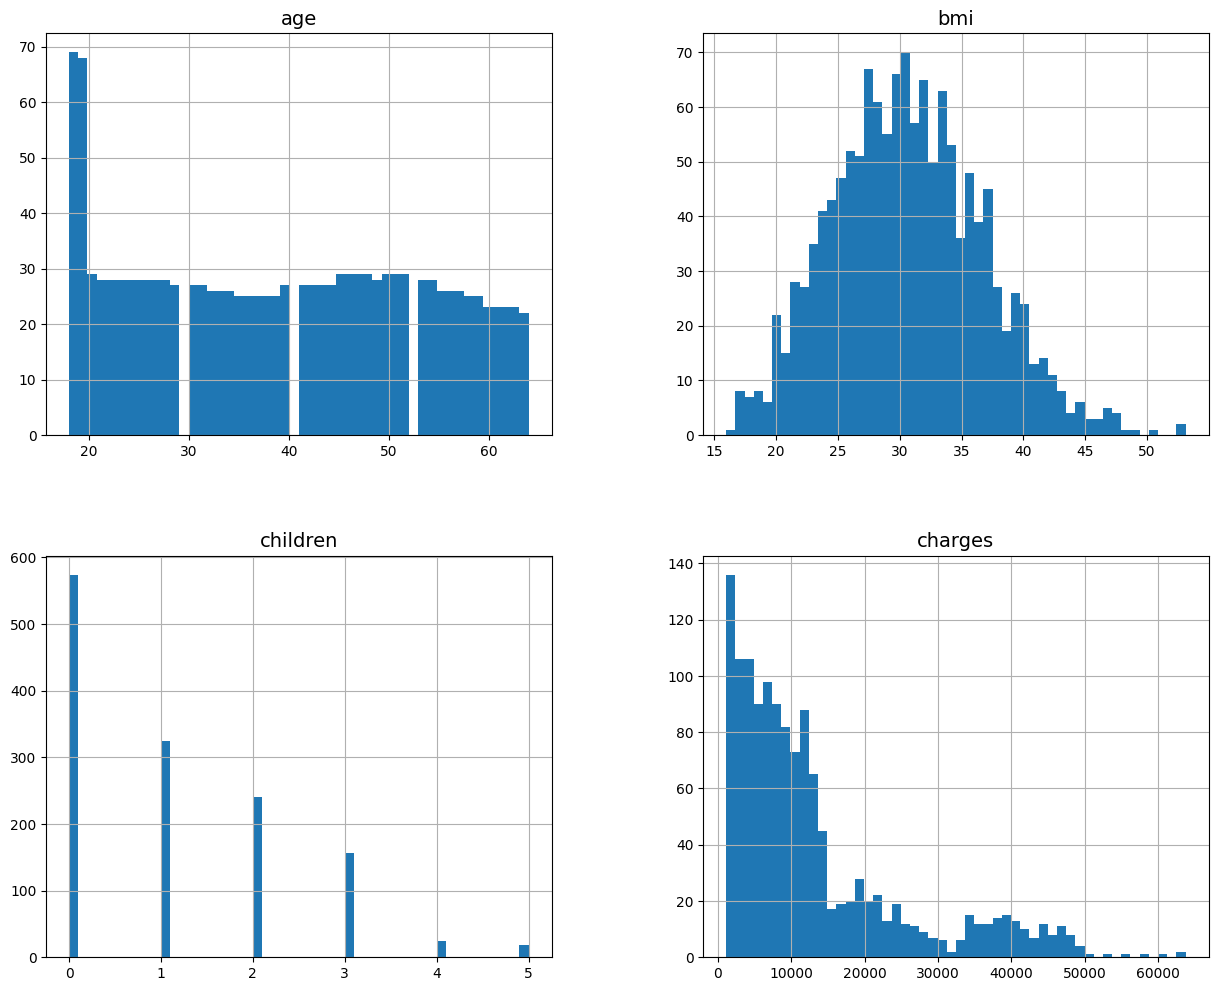

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(15,12))
plt.show()

# Create a Test Set

In [6]:
import numpy as np

df["charges_cat"] = pd.cut(df["charges"],
                               bins = [1120, 4740, 9382, 16639, 30000, np.inf],
                               labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High'])

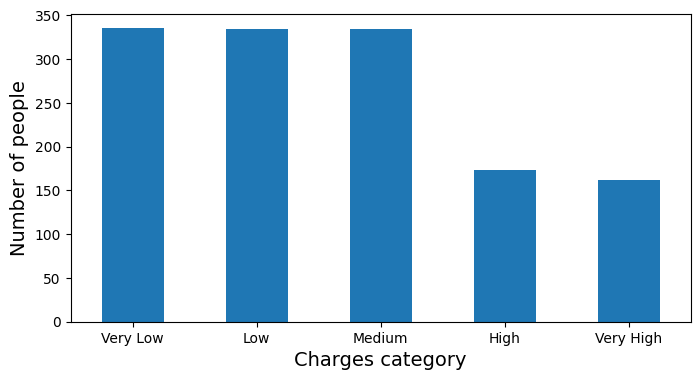

In [7]:
plt.figure(figsize=(8, 4))

df["charges_cat"].value_counts().sort_index().plot.bar(rot=0, grid=False)
plt.xlabel("Charges category")
plt.ylabel("Number of people")

plt.show()

In [8]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, stratify=df['charges_cat'], test_size=0.2, random_state=42)

In [9]:
def income_cat_proportions(data):
    return data["charges_cat"].value_counts() / len(data)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(df),
    "Stratified %": income_cat_proportions(test_set),
}).sort_index()

(compare_props * 100).round(2)

,Overall %,Stratified %
charges_cat,,
Very Low,25.04,25.00
Low,24.96,25.00
Medium,24.96,25.00
High,12.93,13.06
Very High,12.11,11.94


In [10]:
for set_ in (train_set, test_set):
    set_.drop("charges_cat", axis=1, inplace=True)

# Discover and Visualize the Data

In [11]:
insurance = train_set.copy()

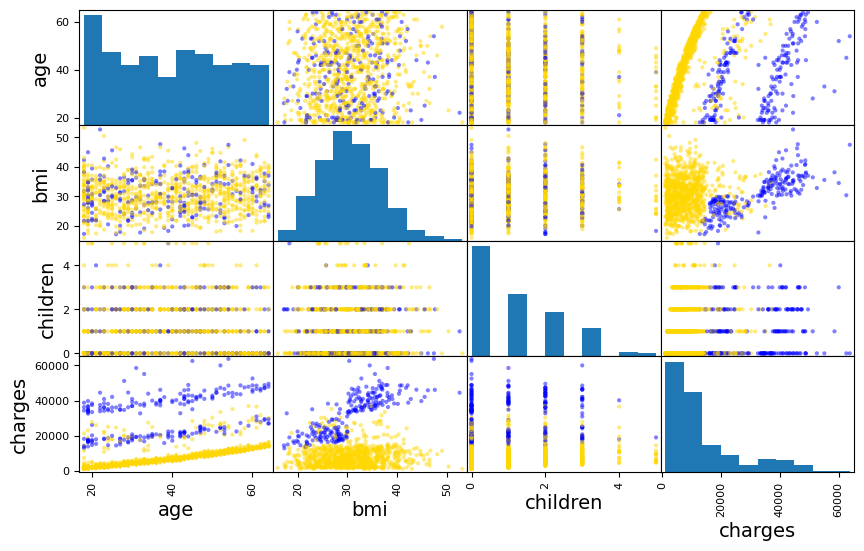

In [12]:
from pandas.plotting import scatter_matrix

colors = insurance['smoker'].map({'yes': 'blue', 'no': 'gold'})
numerical_columns = insurance.select_dtypes(include=['int64', 'float']).columns
scatter_matrix(insurance[numerical_columns], figsize=(10, 6), c=colors)

plt.show()

<Axes: xlabel='age', ylabel='charges'>

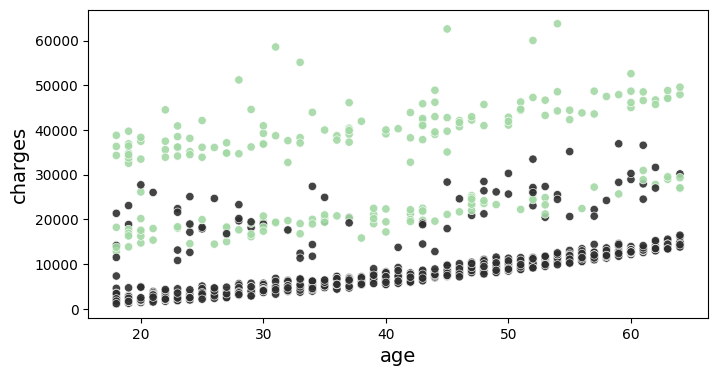

In [13]:
import seaborn as sns

plt.figure(figsize=(8, 4))

colors = insurance['smoker'].map({'yes': '#A3D9A5', 'no': '#2E2E2E'}) # green for smokers, black for non-smokers
sns.scatterplot(x=insurance['age'], y=insurance['charges'], color=colors, alpha=0.9)

We see that as the age increases, the charges do the same on a linear way. However, we can see at least to different grupos:
- If a person is a smoker (green) charges will be higher than those of a person with the same age but non-somker (black)
- Vice-versa
- Then, there is a middle group with charges around 10.000-20.000 in which costs increases as the age raises, but indepent of a person beeing a smoker or not

<Axes: xlabel='bmi', ylabel='charges'>

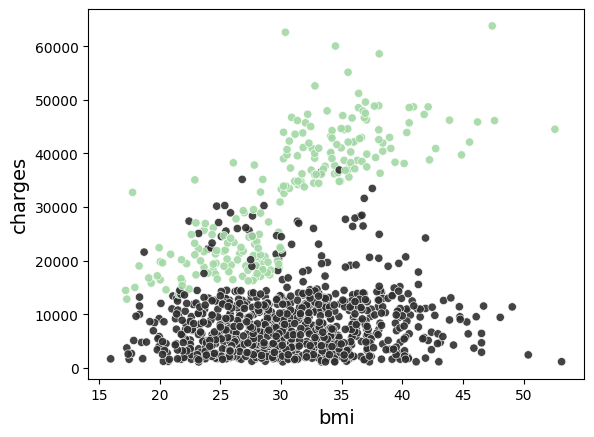

In [14]:
colors = insurance['smoker'].map({'yes': '#A3D9A5', 'no': '#2E2E2E'})
sns.scatterplot(x=insurance['bmi'], y=insurance['charges'], color=colors, alpha=0.9)

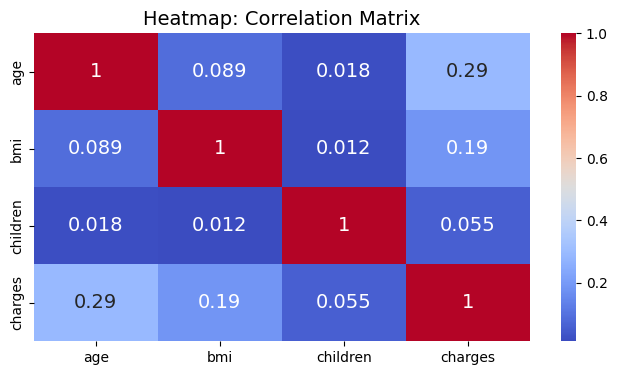

In [15]:
import seaborn as sns

correlation_matrix = insurance[numerical_columns].corr()

plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap: Correlation Matrix')
plt.show()

# Prepare the Data

In [16]:
insurance = train_set.drop("charges", axis=1)
insurance_label = train_set["charges"].copy()

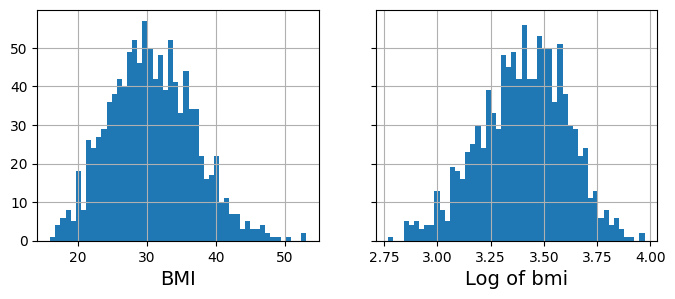

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
insurance["bmi"].hist(ax=axs[0], bins=50)
insurance["bmi"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("BMI")
axs[1].set_xlabel("Log of bmi")

plt.show()

In [18]:
insurance.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

In [19]:
insurance['region'].value_counts()

region
southeast    294
northeast    260
southwest    259
northwest    257
Name: count, dtype: int64

## Transformation Pipeline

In [20]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

cat_attribs = ['sex', 'smoker', 'region']

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder())

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

log_pipeline = make_pipeline(
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

preprocessing = ColumnTransformer([
        ("log", log_pipeline, ["age", "bmi"]),
        ("cat", cat_pipeline, cat_attribs),
    ], remainder='passthrough')

In [22]:
insurance_prepared = preprocessing.fit_transform(insurance)
insurance_prepared.shape

(1070, 11)

In [23]:
insurance.shape

(1070, 6)

In [24]:
preprocessing.get_feature_names_out()

array(['log__age', 'log__bmi', 'cat__sex_female', 'cat__sex_male',
       'cat__smoker_no', 'cat__smoker_yes', 'cat__region_northeast',
       'cat__region_northwest', 'cat__region_southeast',
       'cat__region_southwest', 'remainder__children'], dtype=object)

# Linear Regression

In [25]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())

In [26]:
from sklearn.model_selection import cross_val_score

lin_rmses = -cross_val_score(lin_reg, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(lin_rmses).describe()

count      10.000000
mean     6145.983728
std       683.714780
min      5243.014235
25%      5594.074208
50%      6106.548224
75%      6568.160699
max      7280.824471
dtype: float64

In [27]:
relative_rmse_lin_reg = lin_rmses.mean() / insurance_label.mean()
relative_rmse_lin_reg.round(2)

0.46

In [28]:
lin_reg.fit(insurance, insurance_label)
y_pred = lin_reg.predict(insurance)

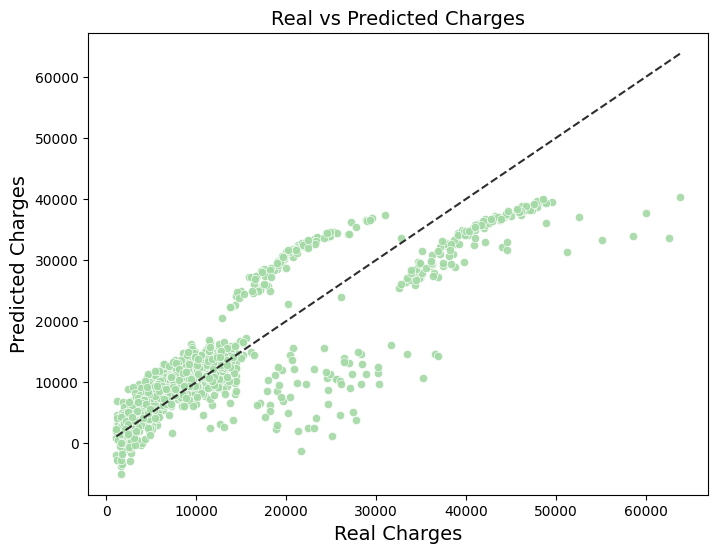

In [29]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=insurance_label, y=y_pred, color='#A3D9A5', alpha=0.9)
sns.lineplot(x=[min(insurance_label), max(insurance_label)], 
             y=[min(insurance_label), max(insurance_label)], 
             color='#2E2E2E', linestyle='--')
plt.xlabel('Real Charges')
plt.ylabel('Predicted Charges')
plt.title('Real vs Predicted Charges')
plt.show()

In [30]:
lin_reg.named_steps['linearregression'].intercept_

20033.553344005737

In [31]:
feature_names = preprocessing.get_feature_names_out()
coef = lin_reg.named_steps['linearregression'].coef_

coef_table = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})

coef_table['Abs_Coefficient'] = coef_table['Coefficient'].abs()
coef_table = coef_table.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)

coef_table

,Feature,Coefficient,Abs_Coefficient
0,cat__smoker_yes,12029.486423,12029.486423
1,cat__smoker_no,-12029.486423,12029.486423
2,log__age,3614.268850,3614.268850
3,log__bmi,2151.880681,2151.880681
4,cat__region_northeast,497.393200,497.393200
5,cat__region_southeast,-382.720109,382.720109
6,cat__region_southwest,-345.606797,345.606797
7,remainder__children,256.420522,256.420522
8,cat__region_northwest,230.933706,230.933706
9,cat__sex_female,157.123557,157.123557


In [32]:
from sklearn.linear_model import SGDRegressor

sgd_reg = make_pipeline(preprocessing, SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)) # penalty=None means no regularization, as we want a linear model. Scikit Learn uses l2 regularization by default.

In [33]:
from sklearn.model_selection import cross_val_score

sgd_rmses = -cross_val_score(sgd_reg, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(sgd_rmses).describe()

count      10.000000
mean     6147.248688
std       683.220228
min      5243.689535
25%      5597.801582
50%      6109.252606
75%      6573.330795
max      7281.980784
dtype: float64

In [34]:
relative_rmse_sgd_lin = lin_rmses.mean() / insurance_label.mean()
relative_rmse_sgd_lin.round(2)

0.46

# Polynomial Regression

In [35]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = make_pipeline(preprocessing, PolynomialFeatures(degree=2, include_bias=False), LinearRegression())

In [36]:
poly_rmses = -cross_val_score(poly_reg, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(poly_rmses).describe()

count      10.000000
mean     4927.039340
std       570.303921
min      4172.729628
25%      4524.334474
50%      4806.446387
75%      5441.963294
max      5667.836687
dtype: float64

In [37]:
relative_rmse_poly_reg = poly_rmses.mean() / insurance_label.mean()
relative_rmse_poly_reg.round(2)

0.37

In [38]:
poly_reg.fit(insurance, insurance_label)
y_pred_poly = poly_reg.predict(insurance)

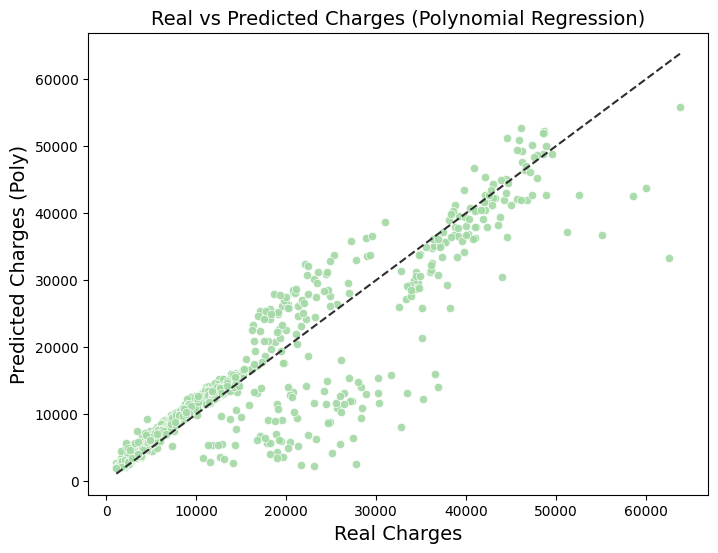

In [39]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=insurance_label, y=y_pred_poly, color='#A3D9A5', alpha=0.9)
sns.lineplot(x=[min(insurance_label), max(insurance_label)], 
             y=[min(insurance_label), max(insurance_label)], 
             color='#2E2E2E', linestyle='--')

plt.xlabel('Real Charges')
plt.ylabel('Predicted Charges (Poly)')
plt.title('Real vs Predicted Charges (Polynomial Regression)')
plt.show()

In [40]:
poly_reg_3 = make_pipeline(preprocessing, PolynomialFeatures(degree=3, include_bias=False), LinearRegression())

poly_rmses_3 = -cross_val_score(poly_reg_3, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

poly_rmses_3.mean()


5129.089469006457

In [41]:
feature_names = poly_reg.named_steps['polynomialfeatures'].get_feature_names_out(preprocessing.get_feature_names_out())
coef = poly_reg.named_steps['linearregression'].coef_

coef_table = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})

coef_table['Abs_Coefficient'] = coef_table['Coefficient'].abs()
coef_table = coef_table.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)

coef_table

,Feature,Coefficient,Abs_Coefficient
0,log__bmi cat__smoker_yes,5499.292078,5499.292078
1,cat__smoker_no,-4460.342887,4460.342887
2,cat__smoker_yes^2,4460.342887,4460.342887
3,cat__smoker_no^2,-4460.342887,4460.342887
4,cat__smoker_yes,4460.342887,4460.342887
...,...,...,...
72,cat__region_northeast cat__region_northwest,0.000000,0.000000
73,cat__region_northwest cat__region_southeast,0.000000,0.000000
74,cat__region_northwest cat__region_southwest,0.000000,0.000000
75,cat__region_southeast cat__region_southwest,0.000000,0.000000


Multiplying categorical variables with the same category (e.g., "male" * "female") doesn't make sense because these variables are binary (1 or 0). The product will always be 0, offering no meaningful contribution to the model. 
Similarly, squaring categorical variables lacks interpretation since categorical features do not have a natural order or scale.

Let's try a Lasso model, which will penalize the coefficients. This will reduce irrelevant features coefficients to 0 as the ones mentioned above.

In [42]:
from sklearn.linear_model import Lasso

poly_reg_lasso = make_pipeline(preprocessing, PolynomialFeatures(degree=2, include_bias=False), 
                               Lasso(alpha=50, max_iter=10000))

In [43]:
poly_lasso_rmses = -cross_val_score(poly_reg_lasso, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(poly_lasso_rmses).describe()

count      10.000000
mean     4864.065077
std       535.982383
min      4157.959080
25%      4458.722911
50%      4772.609116
75%      5307.387225
max      5624.957525
dtype: float64

In [44]:
relative_rmse_poly_reg_lasso = poly_lasso_rmses.mean() / insurance_label.mean()
relative_rmse_poly_reg_lasso.round(2)

0.37

In [45]:
poly_reg_lasso.fit(insurance, insurance_label)
y_pred_poly_lasso = poly_reg_lasso.predict(insurance)

In [46]:
feature_names = poly_reg_lasso.named_steps['polynomialfeatures'].get_feature_names_out(preprocessing.get_feature_names_out())
coef = poly_reg_lasso.named_steps['lasso'].coef_

coef_table = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})

coef_table['Abs_Coefficient'] = coef_table['Coefficient'].abs()
coef_table = coef_table.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)

coef_table[coef_table['Coefficient'] != 0]

,Feature,Coefficient,Abs_Coefficient
0,cat__smoker_no,-2.367541e+04,2.367541e+04
1,log__bmi cat__smoker_yes,8.458657e+03,8.458657e+03
2,log__age,3.815296e+03,3.815296e+03
3,log__age^2,1.231471e+03,1.231471e+03
4,cat__sex_female cat__region_northeast,6.185299e+02,6.185299e+02
5,cat__region_northwest remainder__children,3.965147e+02,3.965147e+02
6,cat__region_northeast remainder__children,3.551138e+02,3.551138e+02
7,cat__sex_male cat__smoker_no,-3.247563e+02,3.247563e+02
8,log__age cat__sex_male,3.119711e+02,3.119711e+02
9,log__age cat__region_southeast,2.647419e+02,2.647419e+02


Interpretation of the coefficients:
1. If a person does not smoke, the charges decline significantly.
2. If a person smokes, the higher the BMI, the higher the charges.
4. The age affects the charges possitively but in a non-linear way


# Regularized Linear Models

## Ridge Regression

In [47]:
from sklearn.linear_model import Ridge

ridge_reg = make_pipeline(preprocessing, Ridge(alpha=0.1, solver="cholesky"))

In [48]:
ridge_rmses = -cross_val_score(ridge_reg, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(ridge_rmses).describe()

count      10.000000
mean     6145.974257
std       683.554345
min      5243.192405
25%      5593.704769
50%      6107.146961
75%      6567.598642
max      7280.622458
dtype: float64

In [49]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'ridge__alpha': np.logspace(-3, 3, 100)
}

random_search = RandomizedSearchCV(
    ridge_reg, param_distributions=param_dist, 
    n_iter=10,  
    scoring='neg_root_mean_squared_error',  
    cv=5,  
    n_jobs=-1, 
    random_state=42
)

random_search.fit(insurance, insurance_label)

/Users/gonzalocaro/Desktop/Empresas - Trabajos/IUMA/Python/Practicas-ML-NN/PracticasIUMA/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('log',
                                                                               Pipeline(steps=[('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<ufunc 'log'>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'bmi']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer...
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [50]:
ridge_reg = random_search.best_estimator_

ridge_rmses = -cross_val_score(ridge_reg, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(ridge_rmses).describe()

count      10.000000
mean     6146.032368
std       681.151244
min      5246.138384
25%      5588.298464
50%      6116.450882
75%      6559.298269
max      7277.725559
dtype: float64

In [51]:
relative_rmse_ridge_reg = ridge_rmses.mean() / insurance_label.mean()
relative_rmse_ridge_reg.round(2)

0.46

In [52]:
ridge_reg.fit(insurance, insurance_label)
y_pred_ridge = ridge_reg.predict(insurance)

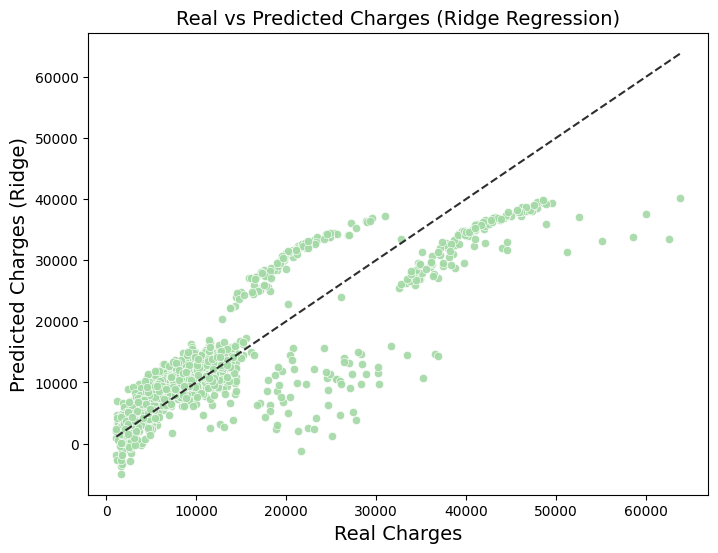

In [53]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=insurance_label, y=y_pred_ridge, color='#A3D9A5', alpha=0.9)
sns.lineplot(x=[min(insurance_label), max(insurance_label)], 
             y=[min(insurance_label), max(insurance_label)], 
             color='#2E2E2E', linestyle='--')

plt.xlabel('Real Charges')
plt.ylabel('Predicted Charges (Ridge)')
plt.title('Real vs Predicted Charges (Ridge Regression)')
plt.show()

In [54]:
feature_names = preprocessing.get_feature_names_out()
coef = ridge_reg.named_steps['ridge'].coef_

coef_table = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})

coef_table['Abs_Coefficient'] = coef_table['Coefficient'].abs()
coef_table = coef_table.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)

coef_table

,Feature,Coefficient,Abs_Coefficient
0,cat__smoker_yes,11972.991510,11972.991510
1,cat__smoker_no,-11972.991510,11972.991510
2,log__age,3607.476734,3607.476734
3,log__bmi,2146.938798,2146.938798
4,cat__region_northeast,493.058477,493.058477
5,cat__region_southeast,-373.383596,373.383596
6,cat__region_southwest,-346.162675,346.162675
7,remainder__children,257.094645,257.094645
8,cat__region_northwest,226.487793,226.487793
9,cat__sex_female,154.854860,154.854860


Under the ridge regression, we regularized by forcing the algorithm to keep the model weights smaller, and not only fitting the data.

In [55]:
from sklearn.linear_model import SGDRegressor

m = len(insurance)

sgd_ridge_reg = make_pipeline(preprocessing, 
                    SGDRegressor(penalty="l2", alpha=1.63 / m, tol=None,
                    max_iter=1000, eta0=0.01, random_state=42)) # penalty="l2" means Ridge Regularization (Ridge Regression), alpha is divided by "m" to get the same result as Ridge Regression.

In [56]:
sgd_ridge_rmses = -cross_val_score(sgd_ridge_reg, insurance, insurance_label,
                                   scoring="neg_root_mean_squared_error", cv=10)

pd.Series(sgd_ridge_rmses).describe()

count      10.000000
mean     6146.179826
std       681.915655
min      5243.623259
25%      5587.618222
50%      6116.414169
75%      6561.030144
max      7276.731622
dtype: float64

## Lasso Regression

In [57]:
from sklearn.linear_model import Lasso

lasso_reg = make_pipeline(preprocessing, Lasso())

In [58]:
param_dist = {
    'lasso__alpha': np.logspace(-3, 3, 100)
}

random_search = RandomizedSearchCV(
    lasso_reg, param_distributions=param_dist, 
    n_iter=10,  
    scoring='neg_root_mean_squared_error',  
    cv=5,  
    n_jobs=-1, 
    random_state=42
)

random_search.fit(insurance, insurance_label)

/Users/gonzalocaro/Desktop/Empresas - Trabajos/IUMA/Python/Practicas-ML-NN/PracticasIUMA/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('log',
                                                                               Pipeline(steps=[('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<ufunc 'log'>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'bmi']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer...
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [59]:
-random_search.best_score_

6149.116038071801

In [60]:
lasso_reg = random_search.best_estimator_

In [61]:
relative_rmse_lasso_reg = -random_search.best_score_.mean() / insurance_label.mean()
relative_rmse_lasso_reg.round(2)

0.46

# Support Vector Machines

## SVM Linear Regression

In [62]:
from sklearn.svm import LinearSVR

svm_reg = make_pipeline(preprocessing,
                        LinearSVR(epsilon=0.1, dual=True, random_state=42, max_iter=10000))

In [63]:
svm_rmses = -cross_val_score(svm_reg, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(svm_rmses).describe()

count       10.000000
mean     15977.121225
std       1418.230797
min      12903.715922
25%      15486.818978
50%      16567.064530
75%      16994.892529
max      17236.134066
dtype: float64

In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'linearsvr__epsilon': [10, 100, 1000, 10000],  
    'linearsvr__C': [10, 100, 500, 1000, 2000],  
}

grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(insurance, insurance_label)

/Users/gonzalocaro/Desktop/Empresas - Trabajos/IUMA/Python/Practicas-ML-NN/PracticasIUMA/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('log',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log'>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'bmi']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('linearsvr',
                                        LinearSVR(dual=True, epsilon=0.1,
                                                  max_iter=10000,
                                                  random_state=42))]),
             param_grid={'linearsvr__C': [10, 100, 500, 1000, 2000],
                         'linearsvr__epsilon': [10, 100, 1000, 10000]},
             scoring='neg_root_mean_squared_error')

In [65]:
-grid_search.best_score_

6598.5555097081815

In [66]:
svm_reg = grid_search.best_estimator_

relative_rmse_svm_reg = -grid_search.best_score_.mean() / insurance_label.mean()
relative_rmse_svm_reg.round(2)

0.5

In [67]:
svm_reg.fit(insurance, insurance_label)
y_pred_svm = svm_reg.predict(insurance)

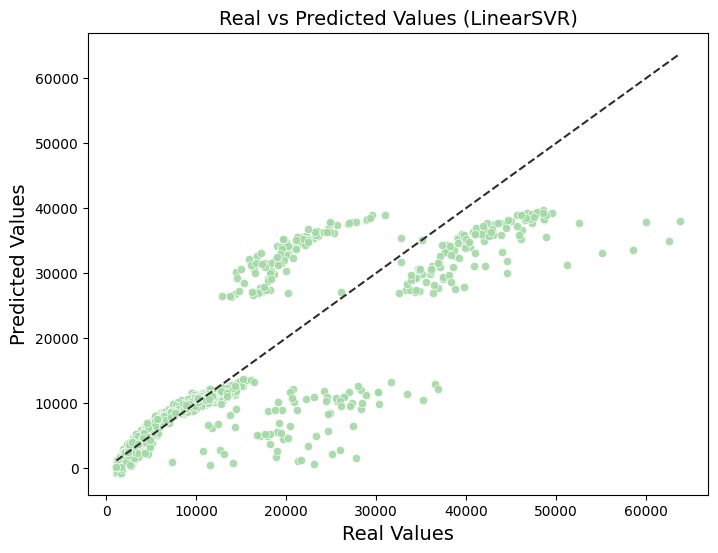

In [68]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=insurance_label, y=y_pred_svm, color='#A3D9A5', alpha=0.9)

# Línea de referencia (identidad, es decir, donde Predicho = Real)
sns.lineplot(x=[min(insurance_label), max(insurance_label)], 
             y=[min(insurance_label), max(insurance_label)], 
             color='#2E2E2E', linestyle='--')

# Etiquetas y título
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs Predicted Values (LinearSVR)')
plt.show()

In [69]:
feature_names = preprocessing.get_feature_names_out()
coef = svm_reg.named_steps['linearsvr'].coef_

coef_table = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})

coef_table['Abs_Coefficient'] = coef_table['Coefficient'].abs()
coef_table = coef_table.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)

coef_table

,Feature,Coefficient,Abs_Coefficient
0,cat__smoker_yes,17749.564070,17749.564070
1,cat__smoker_no,-8816.309325,8816.309325
2,cat__sex_female,4615.167988,4615.167988
3,cat__sex_male,4318.086757,4318.086757
4,log__age,3595.613588,3595.613588
5,cat__region_northeast,2818.758377,2818.758377
6,cat__region_northwest,2233.437919,2233.437919
7,cat__region_southwest,1948.919455,1948.919455
8,cat__region_southeast,1932.138993,1932.138993
9,log__bmi,507.942975,507.942975


## SVM Non Linear Regression 

In [70]:
from sklearn.svm import SVR

svm_poly_reg = make_pipeline(preprocessing,
                             SVR(kernel="poly", degree=2))

In [71]:
svm_poly_rmses = -cross_val_score(svm_poly_reg, insurance, insurance_label,
                                scoring="neg_root_mean_squared_error", cv=10)

pd.Series(svm_poly_rmses).describe()

count       10.000000
mean     12719.325617
std       1179.649025
min      10287.360602
25%      12298.495388
50%      13120.980834
75%      13643.659521
max      13733.267901
dtype: float64

In [72]:
param_grid = {
    'svr__epsilon': [10, 100, 1000, 10000],  
    'svr__C': [10, 100, 1000, 2000],
    'svr__degree': [2, 3, 4, 5]  
}

grid_search = GridSearchCV(svm_poly_reg, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(insurance, insurance_label)

/Users/gonzalocaro/Desktop/Empresas - Trabajos/IUMA/Python/Practicas-ML-NN/PracticasIUMA/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('log',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log'>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'bmi']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('svr', SVR(degree=2, kernel='poly'))]),
             param_grid={'svr__C': [10, 100, 1000, 2000],
                         'svr__degree': [2, 3, 4, 5],
                         'svr__epsilon': [10, 100, 1000, 10000]},
             scoring='neg_root_mean_squared_error')

In [73]:
-grid_search.best_score_

5489.854826402033

In [74]:
svm_poly_reg = grid_search.best_estimator_

relative_rmse_svm_poly_reg = -grid_search.best_score_.mean() / insurance_label.mean()
relative_rmse_svm_poly_reg.round(2)

0.41

In [75]:
svm_poly_reg.fit(insurance, insurance_label)
y_pred_svm_poly = svm_poly_reg.predict(insurance)

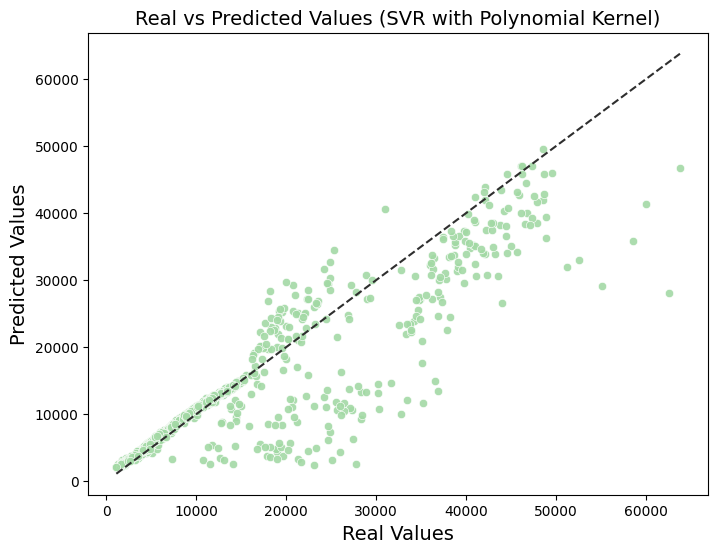

In [76]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=insurance_label, y=y_pred_svm_poly, color='#A3D9A5', alpha=0.9)

# Línea de identidad (donde predicho = real)
sns.lineplot(x=[min(insurance_label), max(insurance_label)], 
             y=[min(insurance_label), max(insurance_label)], 
             color='#2E2E2E', linestyle='--')

plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs Predicted Values (SVR with Polynomial Kernel)')
plt.show()

# Decision Trees

In [77]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))

In [78]:
param_dist = {
    'decisiontreeregressor__min_samples_split': [20, 30, 40, 50],       
    'decisiontreeregressor__min_samples_leaf': [10, 20, 30, 40, 50],        
    'decisiontreeregressor__max_depth': [2, 4, 6, 10],          
}

random_search_tree = RandomizedSearchCV(tree_reg, param_dist, n_iter=100, cv=5, 
                                        scoring='neg_root_mean_squared_error', random_state=42)
random_search_tree.fit(insurance, insurance_label)

/Users/gonzalocaro/Desktop/Empresas - Trabajos/IUMA/Python/Practicas-ML-NN/PracticasIUMA/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/gonzalocaro/Desktop/Empresas - Trabajos/IUMA/Python/Practicas-ML-NN/PracticasIUMA/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('log',
                                                                               Pipeline(steps=[('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<ufunc 'log'>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'bmi']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer...
                                                                                                OneHotEncoder())]),
                                                                               ['sex',
                                                                                'smoker',
                                                                                'region'])])),
                                             ('decisiontreeregressor',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_iter=100,
                   param_distributions={'decisiontreeregressor__max_depth': [2,
                                                                             4,
                                                                             6,
                                                                             10],
                                        'decisiontreeregressor__min_samples_leaf': [10,
                                                                                    20,
                                                                                    30,
                                                                                    40,
                                                                                    50],
                                        'decisiontreeregressor__min_samples_split': [20,
                                                                                     30,
                                                                                     40,
                                                                                     50]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [79]:
-random_search_tree.best_score_

4662.442397011249

In [80]:
tree_reg = random_search_tree.best_estimator_

In [81]:
tree_rmses = -cross_val_score(tree_reg, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(tree_rmses).describe()

count      10.000000
mean     4614.920182
std       596.919389
min      3707.408941
25%      4223.749017
50%      4475.970374
75%      4977.169667
max      5699.994212
dtype: float64

In [82]:
relative_rmse_tree_reg = tree_rmses.mean() / insurance_label.mean()
relative_rmse_tree_reg.round(2)

0.35

In [83]:
tree_reg.fit(insurance, insurance_label)
y_pred_tree = tree_reg.predict(insurance)

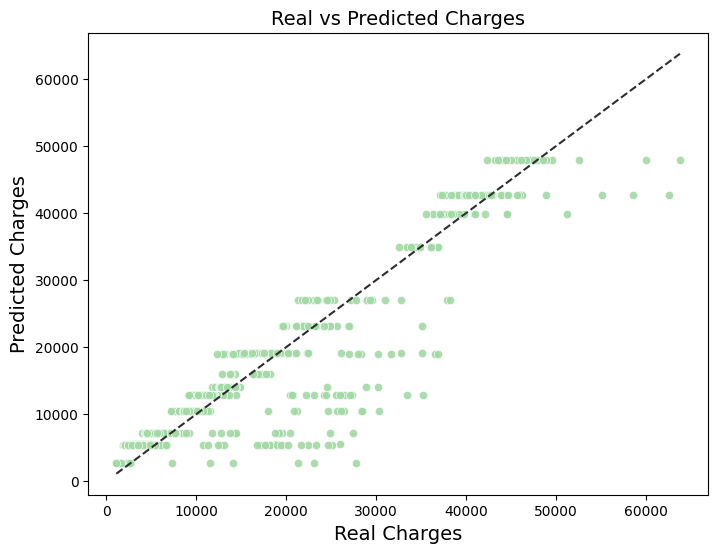

In [84]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=insurance_label, y=y_pred_tree, color='#A3D9A5', alpha=0.9)
sns.lineplot(x=[min(insurance_label), max(insurance_label)], 
             y=[min(insurance_label), max(insurance_label)], 
             color='#2E2E2E', linestyle='--')
plt.xlabel('Real Charges')
plt.ylabel('Predicted Charges')
plt.title('Real vs Predicted Charges')
plt.show()

In [85]:
tree_model = tree_reg.named_steps['decisiontreeregressor']
importances = tree_model.feature_importances_

feature_names_out = preprocessing.get_feature_names_out()

In [86]:
feature_importance = pd.DataFrame({
    'Feature': feature_names_out,
    'Importance': importances
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False).reset_index(drop=True)

feature_importance

,Feature,Importance
0,cat__smoker_no,0.704871
1,log__bmi,0.174090
2,log__age,0.116877
3,remainder__children,0.004162
4,cat__sex_female,0.000000
5,cat__sex_male,0.000000
6,cat__smoker_yes,0.000000
7,cat__region_northeast,0.000000
8,cat__region_northwest,0.000000
9,cat__region_southeast,0.000000


# Random Forest

In [87]:
from sklearn.ensemble import RandomForestRegressor

rdf_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))

In [88]:
param_grid = {
    'randomforestregressor__min_samples_split': [10, 15, 20],       
    'randomforestregressor__min_samples_leaf': [5, 10, 20],        
    'randomforestregressor__max_depth': [4, 6, 10],          
}

grid_search = GridSearchCV(rdf_reg, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(insurance, insurance_label)

/Users/gonzalocaro/Desktop/Empresas - Trabajos/IUMA/Python/Practicas-ML-NN/PracticasIUMA/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('log',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log'>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'bmi']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strat...ost_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'randomforestregressor__max_depth': [4, 6, 10],
                         'randomforestregressor__min_samples_leaf': [5, 10, 20],
                         'randomforestregressor__min_samples_split': [10, 15,
                                                                      20]},
             scoring='neg_root_mean_squared_error')

In [89]:
-grid_search.best_score_

4535.9453874499495

In [90]:
rdf_reg = grid_search.best_estimator_

In [91]:
rdf_rmses = -cross_val_score(rdf_reg, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(rdf_rmses).describe()

count      10.000000
mean     4491.986162
std       583.625342
min      3615.181670
25%      4133.347437
50%      4329.356399
75%      4873.100772
max      5494.776548
dtype: float64

In [92]:
relative_rmse_rdf_reg = rdf_rmses.mean() / insurance_label.mean()
relative_rmse_rdf_reg.round(2)

0.34

In [93]:
rdf_reg.fit(insurance, insurance_label)
y_pred_rdf = rdf_reg.predict(insurance)

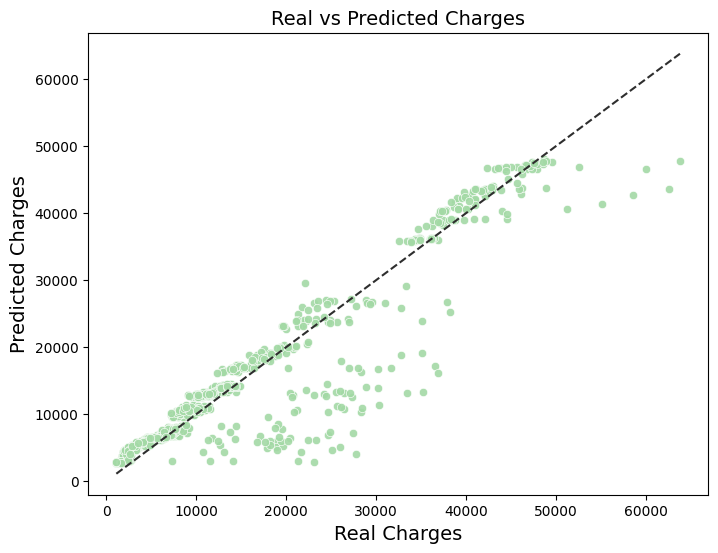

In [94]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=insurance_label, y=y_pred_rdf, color='#A3D9A5', alpha=0.9)
sns.lineplot(x=[min(insurance_label), max(insurance_label)], 
             y=[min(insurance_label), max(insurance_label)], 
             color='#2E2E2E', linestyle='--')
plt.xlabel('Real Charges')
plt.ylabel('Predicted Charges')
plt.title('Real vs Predicted Charges')
plt.show()

In [95]:
rdf_model = rdf_reg.named_steps['randomforestregressor']
importances = rdf_model.feature_importances_

feature_names_out = preprocessing.get_feature_names_out()

In [96]:
feature_importance = pd.DataFrame({
    'Feature': feature_names_out,
    'Importance': importances
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False).reset_index(drop=True)

feature_importance

,Feature,Importance
0,cat__smoker_no,0.394592
1,cat__smoker_yes,0.310247
2,log__bmi,0.173316
3,log__age,0.115021
4,remainder__children,0.005268
5,cat__region_northeast,0.000666
6,cat__region_southeast,0.000238
7,cat__sex_male,0.000208
8,cat__region_northwest,0.000169
9,cat__sex_female,0.000159


# XGBoost

In [97]:
from xgboost import XGBRegressor

xgb_reg = make_pipeline(preprocessing, XGBRegressor(random_state=42))

In [98]:
param_grid = {
    'xgbregressor__n_estimators': [500, 800, 1000],
    'xgbregressor__learning_rate': [0.01, 0.03, 0.05],
    'xgbregressor__max_depth': [5, 7, 9],
    'xgbregressor__min_child_weight': [5, 10, 15],
    'xgbregressor__gamma': [0.05, 0.1, 0.3],
}

grid_search = GridSearchCV(xgb_reg, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(insurance, insurance_label)

/Users/gonzalocaro/Desktop/Empresas - Trabajos/IUMA/Python/Practicas-ML-NN/PracticasIUMA/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('log',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log'>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'bmi']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strat...
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             param_grid={'xgbregressor__gamma': [0.05, 0.1, 0.3],
                         'xgbregressor__learning_rate': [0.01, 0.03, 0.05],
                         'xgbregressor__max_depth': [5, 7, 9],
                         'xgbregressor__min_child_weight': [5, 10, 15],
                         'xgbregressor__n_estimators': [500, 1000, 1500]},
             scoring='neg_root_mean_squared_error')

In [99]:
xgb_reg = grid_search.best_estimator_

In [100]:
xgb_rmses = -cross_val_score(xgb_reg, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(xgb_rmses).describe()

count      10.000000
mean     4536.991667
std       550.216145
min      3741.663004
25%      4211.741771
50%      4422.876677
75%      4918.966417
max      5581.542619
dtype: float64

In [101]:
relative_rmse_xgb_reg = xgb_rmses.mean() / insurance_label.mean()
relative_rmse_xgb_reg.round(2)

0.34

In [102]:
xgb_reg.fit(insurance, insurance_label)
y_pred_xgb = xgb_reg.predict(insurance)

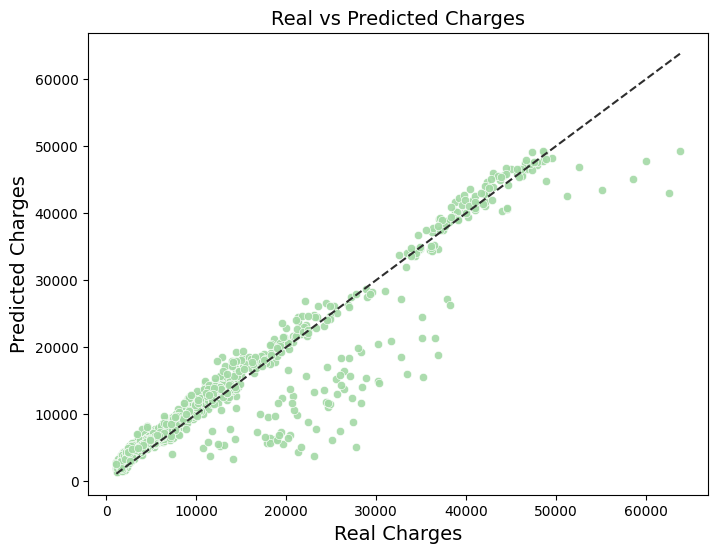

In [103]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=insurance_label, y=y_pred_xgb, color='#A3D9A5', alpha=0.9)
sns.lineplot(x=[min(insurance_label), max(insurance_label)], 
             y=[min(insurance_label), max(insurance_label)], 
             color='#2E2E2E', linestyle='--')
plt.xlabel('Real Charges')
plt.ylabel('Predicted Charges')
plt.title('Real vs Predicted Charges')
plt.show()

In [104]:
xgb_model = xgb_reg.named_steps['xgbregressor']
importances = xgb_model.feature_importances_

feature_names_out = preprocessing.get_feature_names_out()

In [105]:
feature_importance = pd.DataFrame({
    'Feature': feature_names_out,
    'Importance': importances
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False).reset_index(drop=True)

feature_importance

,Feature,Importance
0,cat__smoker_no,0.922611
1,log__bmi,0.034238
2,log__age,0.022333
3,remainder__children,0.005303
4,cat__region_southwest,0.005187
5,cat__region_northeast,0.003445
6,cat__region_northwest,0.002626
7,cat__region_southeast,0.002512
8,cat__sex_female,0.001744
9,cat__sex_male,0.000000
